In [1]:
from tensorflow import keras
import tensorflow as tf
import pandas as pd
from random import sample
import numpy as np

from itertools import product
from itertools import permutations
from itertools import combinations

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

##  ASOptimizer

In [2]:
path='baseline/'
asopt_pred = pd.read_csv(path+'predictions_HIF1A.csv')
LNA_Region = pd.read_csv(path+'LNA_Region B.csv')
LNA_Region_smiles = pd.read_csv(path+'LNA_Region B_smiles.csv')
LNA_Region = LNA_Region.sort_values(by=['Location'])

df_hif1a = pd.read_csv(path+'mmc2.csv')

In [3]:
mode='B'
df_hif1a = df_hif1a[df_hif1a['Type']==mode]

In [4]:
loccs=[]
for ii in range(len(df_hif1a)):
    index = 0
    locs=[]
    while index > -1:
        index = df_hif1a['lnadna'].iloc[ii].find('L',index)
        if index > -1:
            locs.append(str(index))
            locs.append(str('?'))
            index += len('L')
    locs = locs[:-1]
    locs.append(str('/else'))
    loccs.append("".join(locs))

In [5]:
df_hif1a['Location'] = loccs
df_hif1a = df_hif1a.sort_values(by=['Location'])

/home/dclab/hard/genetics/miRNA-main/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Inhibition rate (%)')

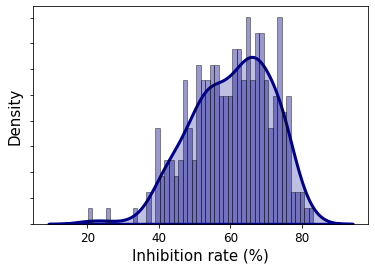

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=10)        # 기본 폰트 크기
plt.rc('axes', labelsize=15)   # x,y축 label 폰트 크기
plt.rc('xtick', labelsize=12)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=12)  # y축 눈금 폰트 크기
plt.rc('legend', fontsize=10)  # 범례 폰트 크기
plt.rc('figure', titlesize=10) # figure title 폰트 크기


value_list = 100-df_hif1a['kd_avg'].values
sns.distplot(value_list, hist=True, kde=True, 
             bins=50, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'shade': True,'linewidth': 3}).set(yticklabels=[])

plt.ylabel('Density')
plt.xlabel('Inhibition rate (%)')

### performance comparison

In [7]:
LNA_Region_smiles['Preds']=asopt_pred['Preds']
LNA_Region_smiles = LNA_Region_smiles.set_index('ISIS')
LNA_Region['preds']=LNA_Region_smiles['Preds']

df_=pd.DataFrame()
df_['predictions']=100*LNA_Region['preds'].values
df_['Gt']=100-df_hif1a['kd_avg'].values

print("R-squared of ASOptimizer: {:.4f}".format(df_.corr().values[0,1])) 

R-squared of ASOptimizer: 0.7271


(10.0, 100.0)

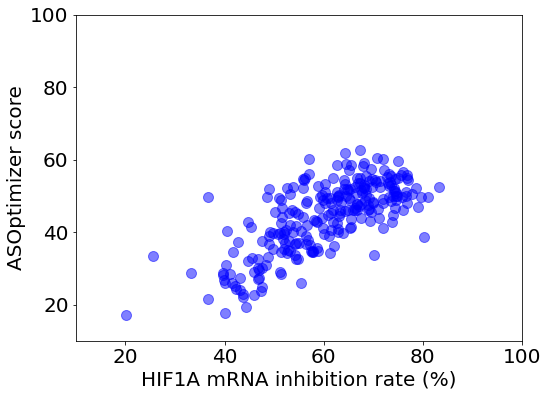

In [8]:
plt.figure(figsize=(8, 6))
plt.rc('font', size=20),        # 기본 폰트 크기
plt.rc('axes', labelsize=20)   # x,y축 label 폰트 크기
plt.rc('xtick', labelsize=20)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=20)  # y축 눈금 폰트 크기
plt.rc('legend', fontsize=20)  # 범례 폰트 크기
plt.rc('figure', titlesize=20) # figure title 폰트 크기

plt.scatter(100-df_hif1a['kd_avg'].values,100*LNA_Region['preds'].values, alpha=0.5,  c='b', s=100)
plt.xlabel('HIF1A mRNA inhibition rate (%)')
plt.ylabel('ASOptimizer score')

plt.xlim([10, 100])
plt.ylim([10, 100])

## Baseline [13] reproduce

In [9]:
df_hif1a = pd.read_csv(path+'mmc2.csv')

lna_df_test = df_hif1a[(df_hif1a['Type']=='A') | (df_hif1a['Type']=='B')]
lna_df_train = df_hif1a[(df_hif1a['Type']=='D')]

tms = lna_df_train['tm_avg'].values
tms_test = lna_df_test['tm_avg'].values

In [10]:
gap_columns = [col for col in lna_df_train.columns if col.startswith('gap.')][1:]
motif_df =lna_df_train[gap_columns].copy()
motif_df = motif_df.loc[:, motif_df.sum() != 0]

In [11]:
#train+test
gap_columns = ['gap.agc', 'gap.gca', 'gap.tcc', 'gap.ctg', 'gap.gcc','gap.tta', 'gap.cct','gap.atc', 'gap.tgc' , 'gap.act','gap.tct','gap.ttc','gap.tgt','gap.tac','gap.ggc','gap.ctt','gap.caa','gap.aag','gap.cat']

In [12]:
df_motif=lna_df_train[gap_columns]
filtered_columns = df_motif

### train/test split

In [13]:
train_x = filtered_columns.copy()

train_x['tm_avg'] =  np.abs(tms - np.array([68] * 128 + [68] * 128))
train_y = lna_df_train['kd_avg'].values

df_motif_test=lna_df_test[gap_columns]
filtered_columns_test = df_motif_test

test_x = filtered_columns_test.copy()
test_x['tm_avg'] =  np.abs(tms_test - np.array([71] * 256 + [67.5] * 256))
test_y = lna_df_test['kd_avg'].values

### robust linear regression

In [14]:
import statsmodels.api as sm

rlm_model = sm.RLM(train_y, sm.add_constant(train_x.values),M=sm.robust.norms.HuberT())
rlm_results = rlm_model.fit()

predictions = rlm_results.predict(sm.add_constant(train_x.values))
predictions_test = rlm_results.predict(sm.add_constant(test_x.values))

In [15]:
rlm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                      y   No. Observations:                  256
Model:                            RLM   Df Residuals:                      235
Method:                          IRLS   Df Model:                           20
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 18 Sep 2023                                         
Time:                        00:54:06                                         
No. Iterations:                    19                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         87.6437      5.209     16.825      0.000      77.434      97.854
x1           -30.0578      3.039     -9.889      0.000     -36.015     -24.101
x2           -19.9110      2.858     -6.968      0.000     -25.512     -14.310
x3           -19.5113      2.966     -6.579      0.000     -25.324     -13.698
x4           -12.8639      2.207     -5.827      0.000     -17.190      -8.537
x5           -11.9287      3.617     -3.298      0.001     -19.017      -4.840
x6            -8.9995      3.662     -2.457      0.014     -16.178      -1.821
x7           -12.4311      2.723     -4.565      0.000     -17.768      -7.094
x8            -8.5956      3.639     -2.362      0.018     -15.728      -1.463
x9           -10.8455      3.173     -3.418      0.001     -17.064      -4.627
x10           -5.8560      3.190     -1.836      0.066     -12.108       0.396
x11           -4.1212      2.796     -1.474      0.140      -9.601       1.359
x12           -3.6456      2.909     -1.253      0.210      -9.348       2.057
x13           -2.4547      4.516     -0.544      0.587     -11.306       6.397
x14           -1.8716      4.448     -0.421      0.674     -10.589       6.846
x15           -2.1160      6.263     -0.338      0.735     -14.391      10.159
x16            0.4432      2.373      0.187      0.852      -4.207       5.093
x17            1.6884      3.047      0.554      0.579      -4.283       7.660
x18           12.1741      2.901      4.196      0.000       6.488      17.860
x19           32.0769      6.271      5.115      0.000      19.786      44.368
x20            2.1045      0.190     11.051      0.000       1.731       2.478
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

### performance comparison

In [16]:
import numpy as np
from scipy.stats import linregress

slope_b, intercept_b, r_value_b, p_value_b, std_err_b = linregress(test_y[256:], predictions_test[256:])

r_squared_b = r_value_b ** 2

print("R-squared of [13]: {:.4f}".format(r_squared_b))
print("R of [13]: {:.4f}".format(r_value_b))

R-squared of [13]: 0.4635
R of [13]: 0.6808


(10.0, 100.0)

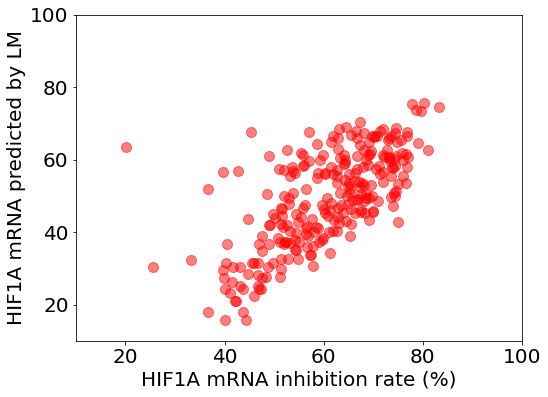

In [17]:
plt.figure(figsize=(8, 6))
plt.rc('font', size=20)       
plt.rc('axes', labelsize=20)  
plt.rc('xtick', labelsize=20)  
plt.rc('ytick', labelsize=20) 
plt.rc('legend', fontsize=20)  
plt.rc('figure', titlesize=20)


plt.scatter(100-test_y[256:], 100-predictions_test[256:], alpha=0.5,  c='r', s=100)
plt.xlabel('HIF1A mRNA inhibition rate (%)')
plt.ylabel('HIF1A mRNA predicted by LM' )

plt.xlim([10, 100])
plt.ylim([10, 100])
